# Fire Dataset_CAM

## 1. Setting

In [5]:
import os, glob
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

## 2. Dataset Introduce

본 데이터셋은 2018년 NASA 우주 앱 챌린지 기간 동안 생성되었으며

화재가 포함된 이미지(화재 이미지)와 일반 이미지(불이 아닌 이미지)를 구별하기 위해 모델을 훈련하기 위해 데이터가 수집되었습니다.

<br /><br />
데이터는 2개의 폴더로 나누어져 있습니다.

fire_images 폴더에는 755개의 실외 화재 이미지가 포함되어 있으며 그 중 일부에는 심한 연기가 포함되어 있습니다.

또한 non_fire_images 폴더에는 244개의 자연 이미지가 포함되어있습니다.

<br /><br />
본 과정에서는 두 개의 이미지 폴더를 이용하여 CAM을 이용한 화재감지 알고리즘을 구현하는 것을 목표로 합니다.

In [2]:
os.environ['KAGGLE_USERNAME'] = 'sinheechan' # username
os.environ['KAGGLE_KEY'] = 'd8cd8b54b5de471688c0790be19a045c' # key

!kaggle datasets download -d phylake1337/fire-dataset

100% 387M/387M [00:07<00:00, 86.3MB/s]
100% 387M/387M [00:07<00:00, 53.0MB/s]


In [3]:
!unzip -q fire-dataset.zip

## 3. EDA

In [6]:
path='/content/fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,non_fire_images
1,fire_images


755
244


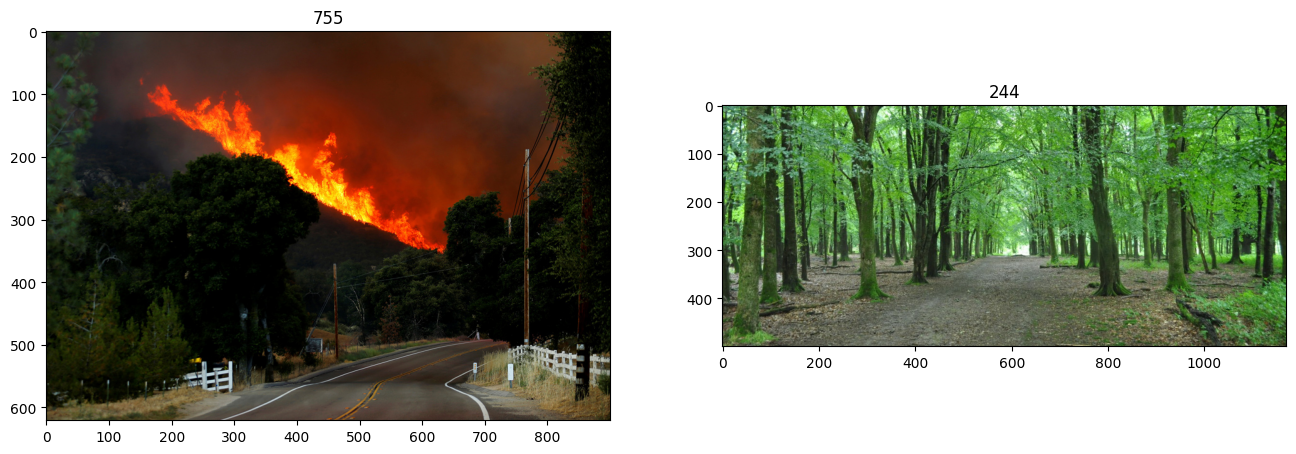

In [16]:
# Preview Dataset
BASE_PATH = 'data'

full_list = glob.glob(os.path.join(BASE_PATH, '/content/fire_dataset/Full/*.png')) # 다 찼음
free_list = glob.glob(os.path.join(BASE_PATH, '/content/fire_dataset/Free/*.png')) # 비었음

print(len(full_list)) # 2095장
print(len(free_list)) # 1067장

# 이미지를 넘파이 배열로 변환
full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))

# full_list
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)


# free_list
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

## 4. Data Engineering

ImageDataGenerator 객체를 설정합니다.

주어진 이미지를 모델에 제공하기 전에 Train / Val 각 데이터셋 별 데이터를 증강 및 전처리하는 작업을 진행합니다.

In [19]:
# train data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

# val data
val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

디렉토리에서 이미지를 로드하고, 데이터를 배치 단위로 생성하여 신경망 모델에 제공하는데 사용되는 제너레이터(Generator)를 설정합니다.

In [20]:
train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 900 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


## 5. Model

MobileNetV2 모델을 기본 네트워크로 사용하여 새로운 분류기를 추가하는 작업을 수행합니다.

MobileNetV2는 작고 경량화된 딥러닝 모델로, 모바일 및 임베디드 기기에서 컴퓨터 비전 작업을 수행하기 위한 검증된 모델입니다.

Global Average Pooling 층을 추가하여 3차원 특성 맵을 1차원으로 변환합니다.

이는 공간 정보를 유지하면서 차원을 축소하는 역할을 서포트합니다.

In [21]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False) #1000이미지 분류 모델

x = base_model.output
x = GlobalAveragePooling2D()(x) # Add Global Average Pooling
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개 분류 출력

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

trainable을 True로 설정하여 해당 특정 층의 가중치가 훈련 중에 업데이트되도록 합니다.

In [22]:
for layer in model.layers:
    layer.trainable = True

## 6. Test

In [24]:
# Train
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('btmodel.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

<ipython-input-24-aff83047cbe0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 0.2539 - acc: 0.9333
Epoch 1: val_acc improved from -inf to 0.91919, saving model to btmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 57s 1s/step - loss: 0.2539 - acc: 0.9333 - val_loss: 0.4053 - val_acc: 0.9192
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.0848 - acc: 0.9800
Epoch 2: val_acc improved from 0.91919 to 0.92929, saving model to btmodel.h5
29/29 [==============================] - 29s 990ms/step - loss: 0.0848 - acc: 0.9800 - val_loss: 0.5645 - val_acc: 0.9293
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.0624 - acc: 0.9811
Epoch 3: val_acc improved from 0.92929 to 0.96970, saving model to btmodel.h5
29/29 [==============================] - 29s 984ms/step - loss: 0.0624 - acc: 0.9811 - val_loss: 0.2134 - val_acc: 0.9697
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.0705 - acc: 0.9767
Epoch 4: val_acc improved from 0.96970 to 0.98990, saving model to btmodel.h5
29/29 [==============================] - 29s 999ms/step - loss: 0.0705 - acc: 0.9767 - val_loss: 0.0630 - val_acc: 0.9899
Epoch 5/10
29/

사전에 저장된 모델 파일(btmodel.h5)을 로드하고, 해당 모델에서 필요한 부분을 추출하여 새로운 모델을 생성합니다.

In [25]:
model = load_model('btmodel.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2) 차원수

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

지정한 이미지에 대한 모델의 예측을 수행하고, 입력 이미지를 시각화합니다.

1/1 [==============================] - 0s 45ms/step


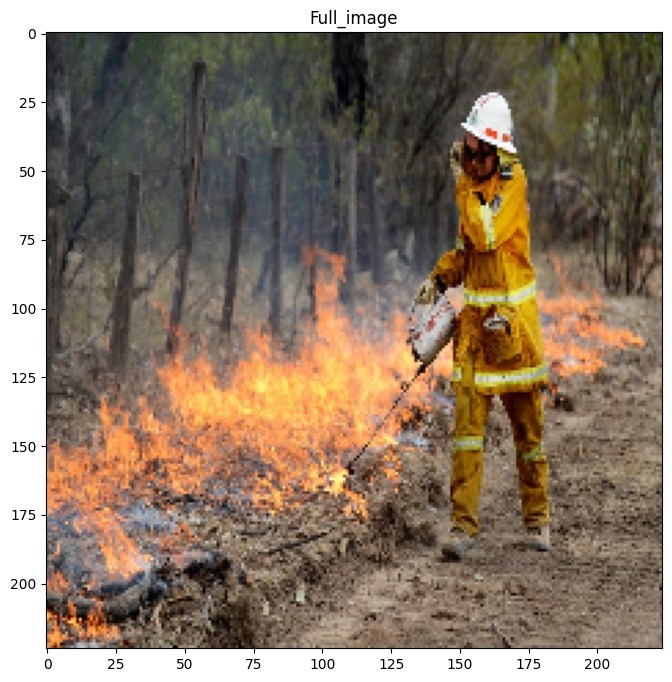

In [30]:
test_img = img_to_array(load_img(os.path.join(BASE_PATH, '/content/data/Full/fire.114.png'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('Full_image' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

모델이 입력 이미지의 어떤 중요한 부분을 인식하였는지 확인하기 위해 Activation Map을 그립니다.

1/1 [==============================] - 1s 1s/step


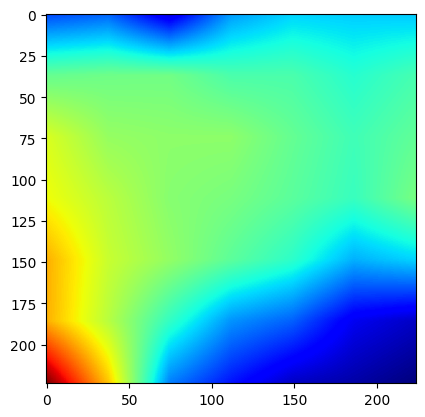

In [31]:
# Activation Map
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1)

pred_class = np.argmax(pred)
predicted_class_weights = last_weight[:, pred_class]

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224))
plt.imshow(final_output, cmap='jet')

원본image 와 Activation Map 을 대조하여 성능을 검증합니다.

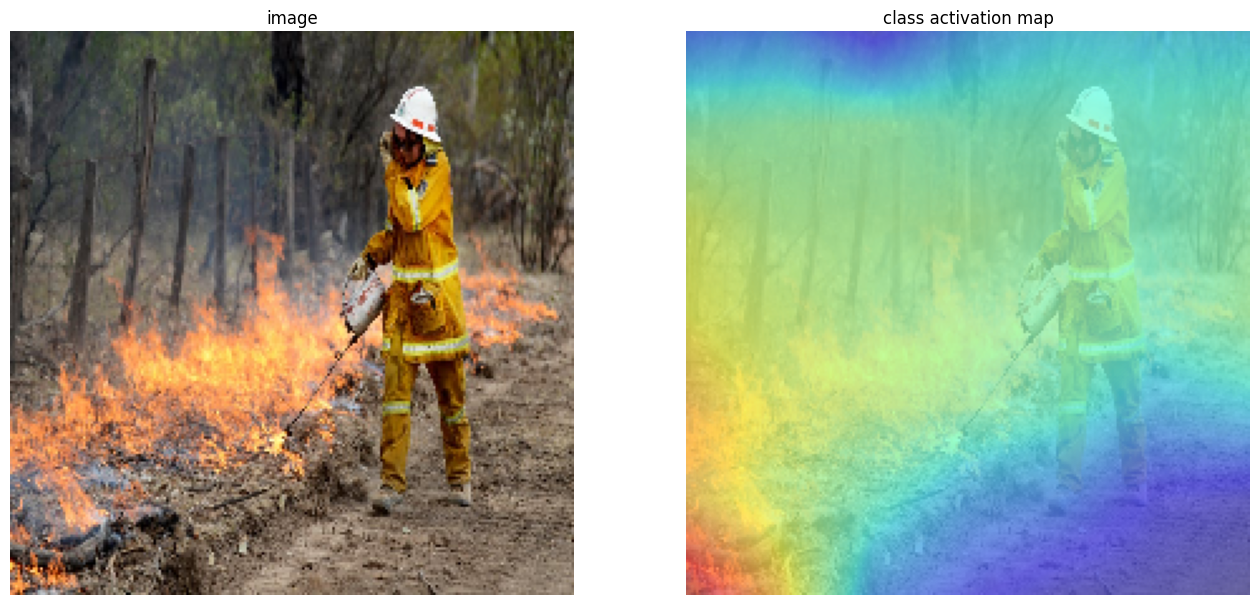

In [32]:
# result
# 서로 크로스오버해서 보기

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()